In [1]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import os
import sklearn.preprocessing as prep
import plotly.graph_objects as go
import plotly
   
Comp = ['S2000001', 'S2000002', 'S2000003', 'S2000004']

namee1 = '/home/mabbasloo/Documents/carCrashData/f001_S2000001_1.mat' 
namee2 = '/home/mabbasloo/Documents/carCrashData/f001_S2000002_1.mat' 
namee3 = '/home/mabbasloo/Documents/carCrashData/f001_S2000003_1.mat'
namee4 = '/home/mabbasloo/Documents/carCrashData/f001_S2000004_1.mat'

namee = [namee1, namee2, namee3, namee4]

name1 = '/home/mabbasloo/Documents/carCrashData/S2000001/data/'
name2 = '/home/mabbasloo/Documents/carCrashData/S2000002/data/'
name3 = '/home/mabbasloo/Documents/carCrashData/S2000003/data/'
name4 = '/home/mabbasloo/Documents/carCrashData/S2000004/data/'

name = [name1, name2, name3, name4]

files = ['1', '2', '3', '4']
DIMM = [1714, 1736, 1519, 1705]
P = len(DIMM)

loading data

In [2]:
DATAall = []
dataall = []
st = 10
stride = 6
d = 40
for p in range(P):
    filename = '/home/mabbasloo/Documents/carCrashData/200000' + files[p]
    with open(filename) as f:
        data = f.readlines() 
    data = [x.strip() for x in data]   
    data = sorted(data, key=lambda x:x[0:4])[0::stride]
    dataall.append(data)
    DATA = []
    hm = len(data)
    dimm = DIMM[p]
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    for i in range(hm):
        db1 = h5py.File(name[p] + data[i], 'r')
        ds1 = db1['shape_xyz']
        ds1 = np.asarray(ds1).astype(np.float32)
        ds1[np.isnan(ds1)] = 0.0
        ds1[np.isinf(ds1)] = 0.0   
        if ds1.shape[1] == DIMM[p]:
            DATA.append(np.dot(ds1, ds))
        else:
            print (data[i])
    DATAall.append(DATA)   
print (len(DATAall), len(DATAall[0]), DATAall[0][0].shape) 

4 2050 (3, 40)


In [3]:
DATA = []
for i in range(len(DATAall[0])):
    dummy = np.zeros((3, d*P))
    for j in range(P):
        dummy[:, j*d:(j+1)*d] = DATAall[j][i]
    DATA.append(dummy)
DATA = np.asarray(DATA)        
print (len(DATA), DATA[0].shape)    

2050 (3, 160)


normalization

In [4]:
lx = np.linalg.norm(np.asarray(DATA[0,:,:]))
ly = np.linalg.norm(np.asarray(DATA[0,:,:]))
lz = np.linalg.norm(np.asarray(DATA[0,:,:]))
print (lx, ly, lz)
for i in range(hm):
    DATA[i,0] = DATA[i,0]/lx
    DATA[i,1] = DATA[i,1]/ly
    DATA[i,2] = DATA[i,2]/lz  

19942.80223512423 19942.80223512423 19942.80223512423


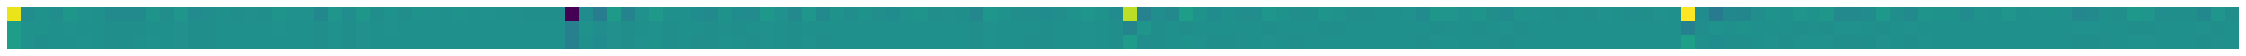

In [5]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)
plt.figure(figsize=(d, d));
plt.axis('off')
plt.imshow(DATA[0])

In [6]:
ch = ['red', 'blue', 'green', 'yellow']
for p in range(P):
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0 
    
    info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
    info = info['shape_TRIV']
    info = np.asarray(info).astype(np.int32) 
    
    xyz = np.dot(DATAall[p][0], np.linalg.pinv(ds)) 
    datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, color=ch[p], showscale=True)]
    layout = go.Layout(
        width=600, height=600, 
        scene=go.layout.Scene(
            xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            camera = dict(
               up=dict(x=0, y=0, z=1),
               center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=2, z=2)
            )
        )
    )
    fig = go.Figure(data=datap, layout=layout)
    #fig.show()
    fig.write_image('comp_' + np.str(p) + '.png')

average error

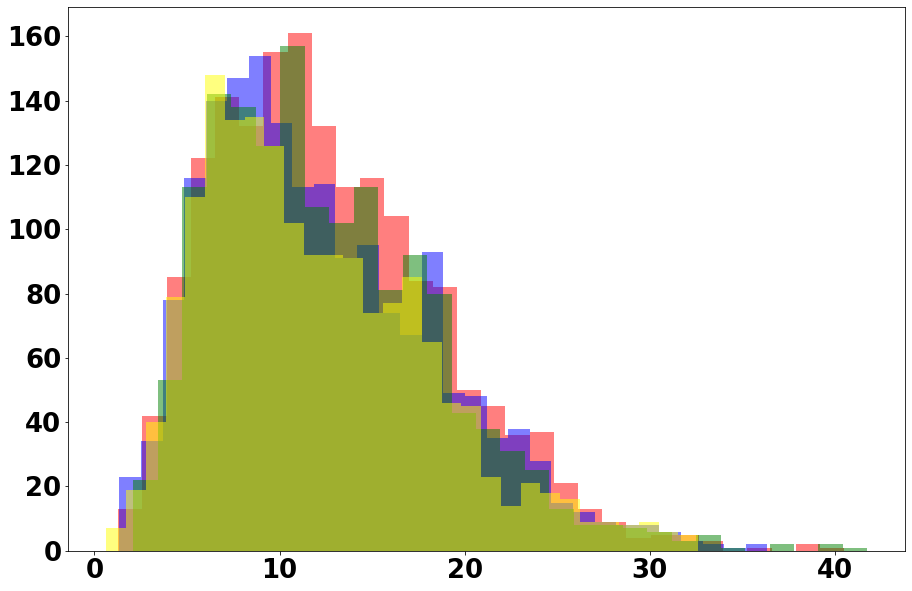

In [26]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
for p in range(P):
    ds = h5py.File(namee[p], 'r')
    ds = ds['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    
    info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
    info = info['shape_TRIV']
    info = np.asarray(info).astype(np.int32) 
    
    cl = np.zeros((DIMM[p]))
    for i in range(len(DATAall[0])):
        db = h5py.File(name[p] + dataall[p][i], 'r')
        db = db['shape_xyz']
        db = np.asarray(db).astype(np.float32)
        xyz = np.dot(DATAall[p][i], np.linalg.pinv(ds))
        cl += np.linalg.norm(np.abs(xyz - db), axis=0)/2050.0
    ax.hist(cl, bins=30, color=ch[p], alpha=0.5)
    
    xyz = np.dot(DATAall[p][0], np.linalg.pinv(ds))
    datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=cl, showscale=True, cmax=45, cmin=0)]
    layout = go.Layout(
        width=600, height=600, 
        scene=go.layout.Scene(
            xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            camera = dict(
               up=dict(x=0, y=0, z=1),
               center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=2, z=2)
            )
        )
    )
    figp = go.Figure(data=datap, layout=layout)
    #figp.show()
    figp.write_image('compAvEr_' + np.str(p) + '.png')

In [8]:
dim = np.int(len(data)/st)
DATA3 = []
for i in range(dim):
    D = np.asarray(DATA[i*st:(i+1)*st]).reshape(st*3, P*d)
    DATA3.append(D)
print (len(DATA3), DATA3[0].shape)  
ddd = st*3
print (ddd, d, dim)
dim3 = 155

205 (30, 160)
30 40 205


network

In [9]:
# lstm autoencoder reconstruct and predict sequence
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model


# define input sequence
#[samples, timesteps, features]
seq_in = []
for j in range(dim3):
    seq_in.append(DATA3[j].reshape(st, 3*d*P))
seq_in = np.asarray(seq_in)  
print (seq_in.shape)

seq_test = []
for j in range(dim3, dim):
    seq_test.append(DATA3[j].reshape(st, 3*d*P))
seq_test = np.asarray(seq_test)  
print (seq_test.shape)

n_in = seq_in.shape[1]

# prepare output sequence
l = np.int(st/2)
seq_out = seq_in[:, l:, :]
n_out = n_in - l

# define encoder
visible = Input(shape=(n_in, 3*d*P))
encoder = LSTM(1000, activation='relu')(visible)

# define reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(1500, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(3*d*P))(decoder1)

# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(2000, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(3*d*P))(decoder2)

# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

Using TensorFlow backend.
W0923 18:58:44.133264 140705197295424 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 18:58:44.252503 140705197295424 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



(155, 10, 480)
(50, 10, 480)


W0923 18:58:44.398003 140705197295424 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 18:58:54.964728 140705197295424 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [10]:
# fit model
model.fit(seq_in, [seq_in,seq_out], epochs=100, verbose=0)

W0923 18:58:55.975939 140705197295424 deprecation.py:323] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0923 18:58:57.075096 140705197295424 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0923 18:58:57.190140 140705197295424 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [32]:
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)

print (len(yhat), yhat[0].shape)

2 (155, 10, 480)


errors

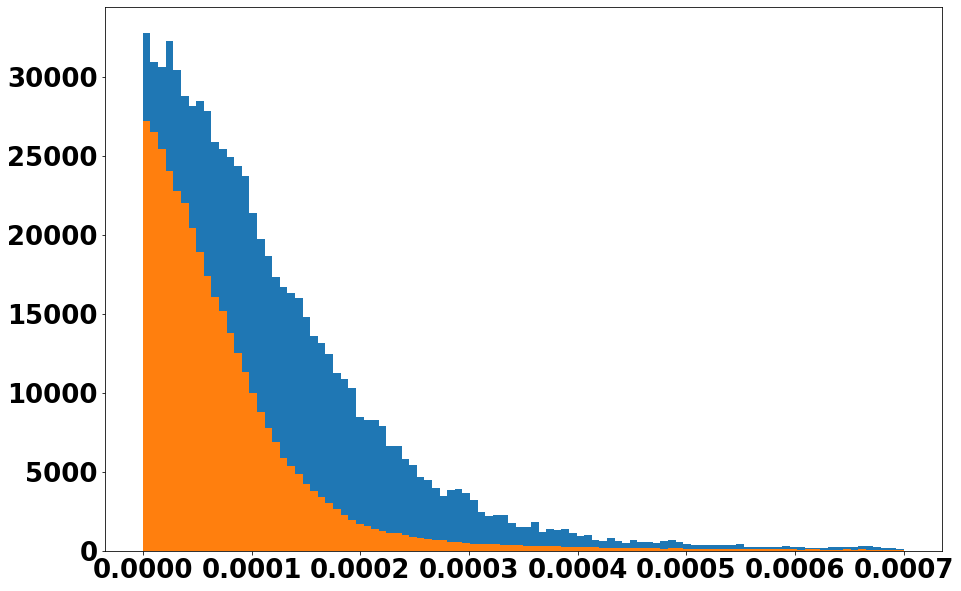

In [33]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
_,_,_ = ax.hist(np.abs(yhat[0] - seq_in).reshape(seq_in.shape[0]*seq_in.shape[1]*seq_in.shape[2]), bins=100, range=[0.0,0.0007])
_,_,_ = ax.hist(np.abs(yhat[1] - seq_in[:, l:, :]).reshape(seq_in.shape[0]*(seq_in.shape[1]-l)*seq_in.shape[2]), bins=100, range=[0.0,0.0007])

In [34]:
# demonstrate prediction
yhat = model.predict(seq_test, verbose=0)

print (len(yhat), yhat[0].shape)

2 (50, 10, 480)


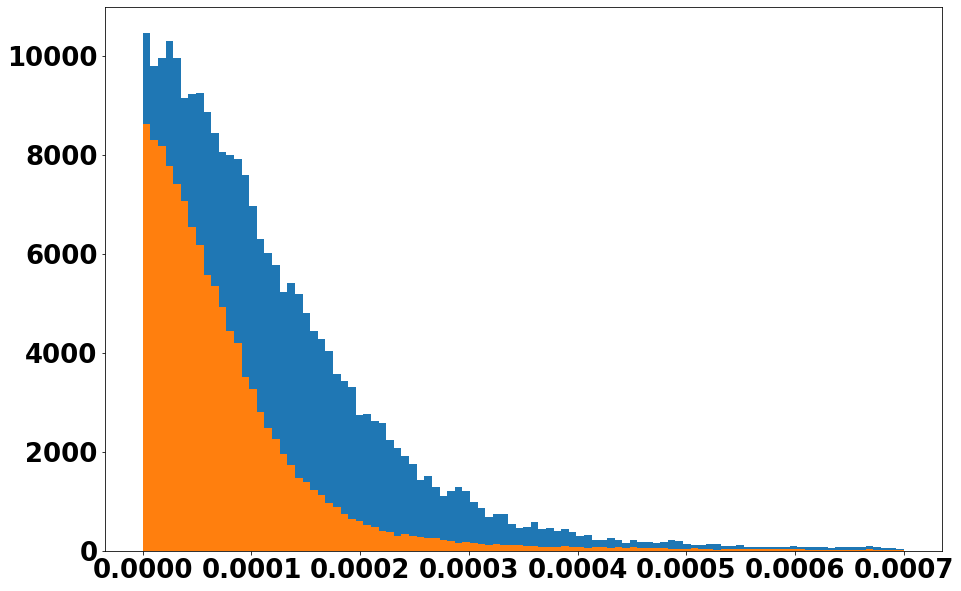

In [35]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
_,_,_ = ax.hist(np.abs(yhat[0] - seq_test).reshape(seq_test.shape[0]*seq_test.shape[1]*seq_test.shape[2]), bins=100, range=[0.0,0.0007])
_,_,_ = ax.hist(np.abs(yhat[1] - seq_test[:, l:, :]).reshape(seq_test.shape[0]*(seq_test.shape[1]-l)*seq_test.shape[2]), bins=100, range=[0.0,0.0007])

loading first branch of bifurcation

In [15]:
DATAallbr1 = []
filename = '/home/mabbasloo/Documents/carCrashData/br1'
dimbr1 = 71
with open(filename) as f:
    databr1 = f.readlines()
databr1 = [x.strip() for x in databr1]     
hmbr1 = len(databr1)    
for p in range(P):
    DATAbr1 = []
    dimm = DIMM[p]
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    for j in range(hmbr1):
        for k in range(1, 60+1, stride):
            nameHere = 'f' + databr1[j] + '_' + Comp[p] + '_' + np.str(k) + '.mat'
            db1 = h5py.File(name[p] + nameHere, 'r')
            ds1 = db1['shape_xyz']
            ds1 = np.asarray(ds1).astype(np.float32)
            ds1[np.isnan(ds1)] = 0.0
            ds1[np.isinf(ds1)] = 0.0   
            if ds1.shape[1] == DIMM[p]:
                DATAbr1.append(np.dot(ds1, ds))
    DATAallbr1.append(DATAbr1)   
print (len(DATAallbr1), len(DATAallbr1[0]), DATAallbr1[0][0].shape) 

DATAbr1 = []
for i in range(len(DATAallbr1[0])):
    dummy = np.zeros((3, d*P))
    for j in range(P):
        dummy[:, j*d:(j+1)*d] = DATAallbr1[j][i]
    DATAbr1.append(dummy)
print (len(DATAbr1), DATAbr1[0].shape)  

for i in range(dimbr1*st):
    DATAbr1[i][0] = DATAbr1[i][0]/lx
    DATAbr1[i][1] = DATAbr1[i][1]/ly
    DATAbr1[i][2] = DATAbr1[i][2]/lz 

DATA3br1 = []
for i in range(dimbr1):
    D = np.asarray(DATAbr1[i*st:(i+1)*st]).reshape(st*3, P*d)
    DATA3br1.append(D)  

seq_testbr1 = []
for j in range(dimbr1):
    seq_testbr1.append(DATA3br1[j].reshape(st, 3*d*P))
seq_testbr1 = np.asarray(seq_testbr1)
print (seq_testbr1.shape)   

4 710 (3, 40)
710 (3, 160)
(71, 10, 480)


In [16]:
# demonstrate prediction
yhatbr1 = model.predict(seq_testbr1, verbose=0)

loading second branch of bifurcation

In [17]:
DATAallbr2 = []
filename = '/home/mabbasloo/Documents/carCrashData/br2'
dimbr2 = 134
with open(filename) as f:
    databr2 = f.readlines()
databr2 = [x.strip() for x in databr2]     
hmbr2 = len(databr2)    
for p in range(P):
    DATAbr2 = []
    dimm = DIMM[p]
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    for j in range(hmbr2):
        for k in range(1, 60+1, stride):
            nameHere = 'f' + databr2[j] + '_' + Comp[p] + '_' + np.str(k) + '.mat'
            db1 = h5py.File(name[p] + nameHere, 'r')
            ds1 = db1['shape_xyz']
            ds1 = np.asarray(ds1).astype(np.float32)
            ds1[np.isnan(ds1)] = 0.0
            ds1[np.isinf(ds1)] = 0.0   
            if ds1.shape[1] == DIMM[p]:
                DATAbr2.append(np.dot(ds1, ds))
    DATAallbr2.append(DATAbr2)   
print (len(DATAallbr2), len(DATAallbr2[0]), DATAallbr2[0][0].shape) 

DATAbr2 = []
for i in range(len(DATAallbr2[0])):
    dummy = np.zeros((3, d*P))
    for j in range(P):
        dummy[:, j*d:(j+1)*d] = DATAallbr2[j][i]
    DATAbr2.append(dummy)
print (len(DATAbr2), DATAbr2[0].shape)  

for i in range(dimbr2*st):
    DATAbr2[i][0] = DATAbr2[i][0]/lx
    DATAbr2[i][1] = DATAbr2[i][1]/ly
    DATAbr2[i][2] = DATAbr2[i][2]/lz 

DATA3br2 = []
for i in range(dimbr2):
    D = np.asarray(DATAbr2[i*st:(i+1)*st]).reshape(st*3, P*d)
    DATA3br2.append(D)  

seq_testbr2 = []
for j in range(dimbr2):
    seq_testbr2.append(DATA3br2[j].reshape(st, 3*d*P))
seq_testbr2 = np.asarray(seq_testbr2)
print (seq_testbr2.shape)    

4 1340 (3, 40)
1340 (3, 160)
(134, 10, 480)


In [18]:
# demonstrate prediction
yhatbr2 = model.predict(seq_testbr2, verbose=0)

errors averages for both branches 

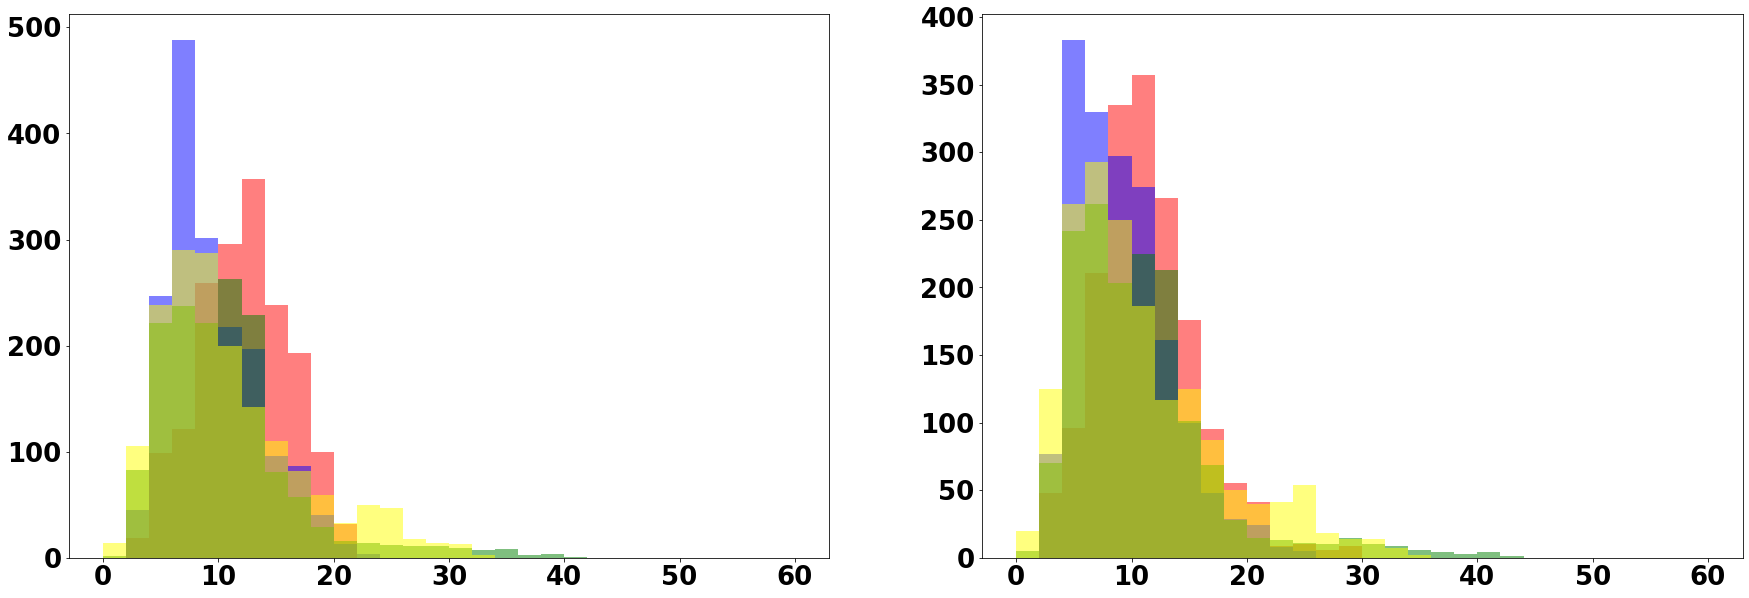

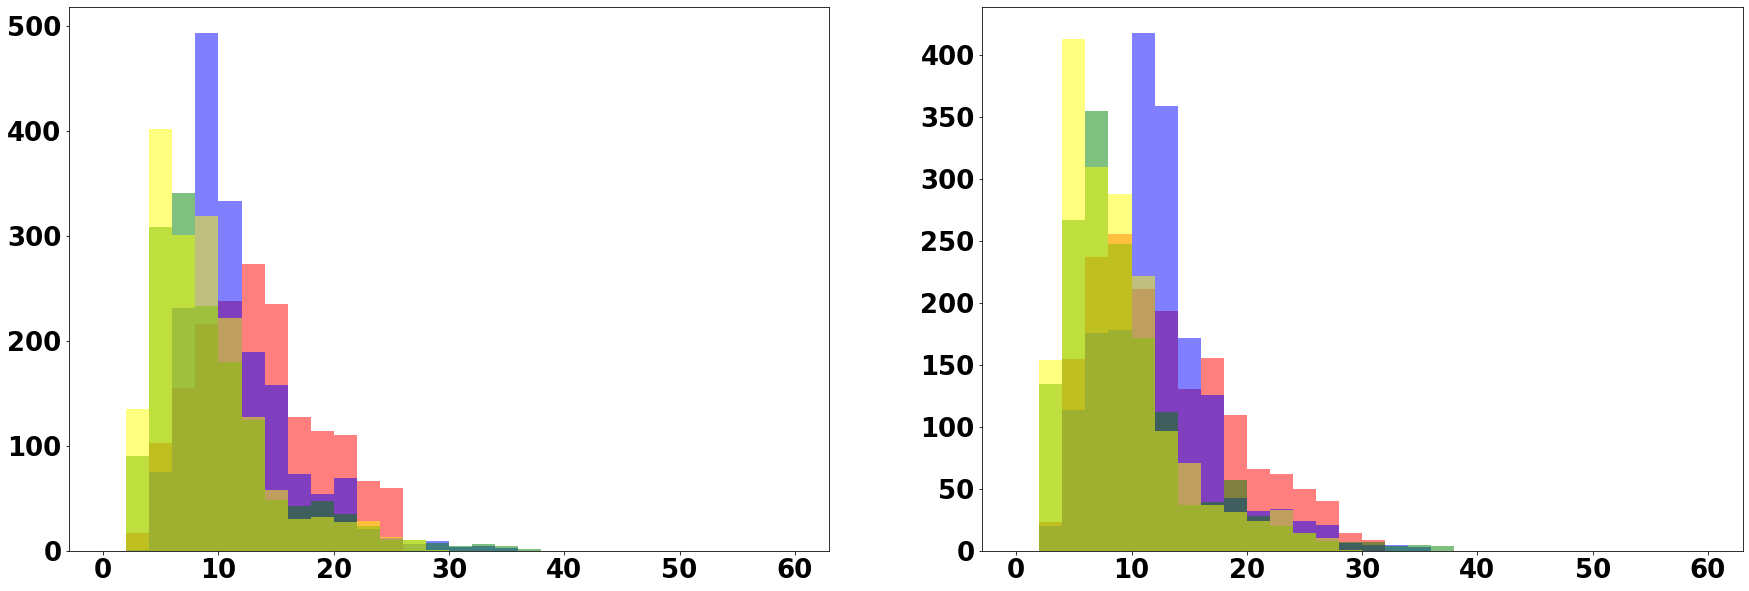

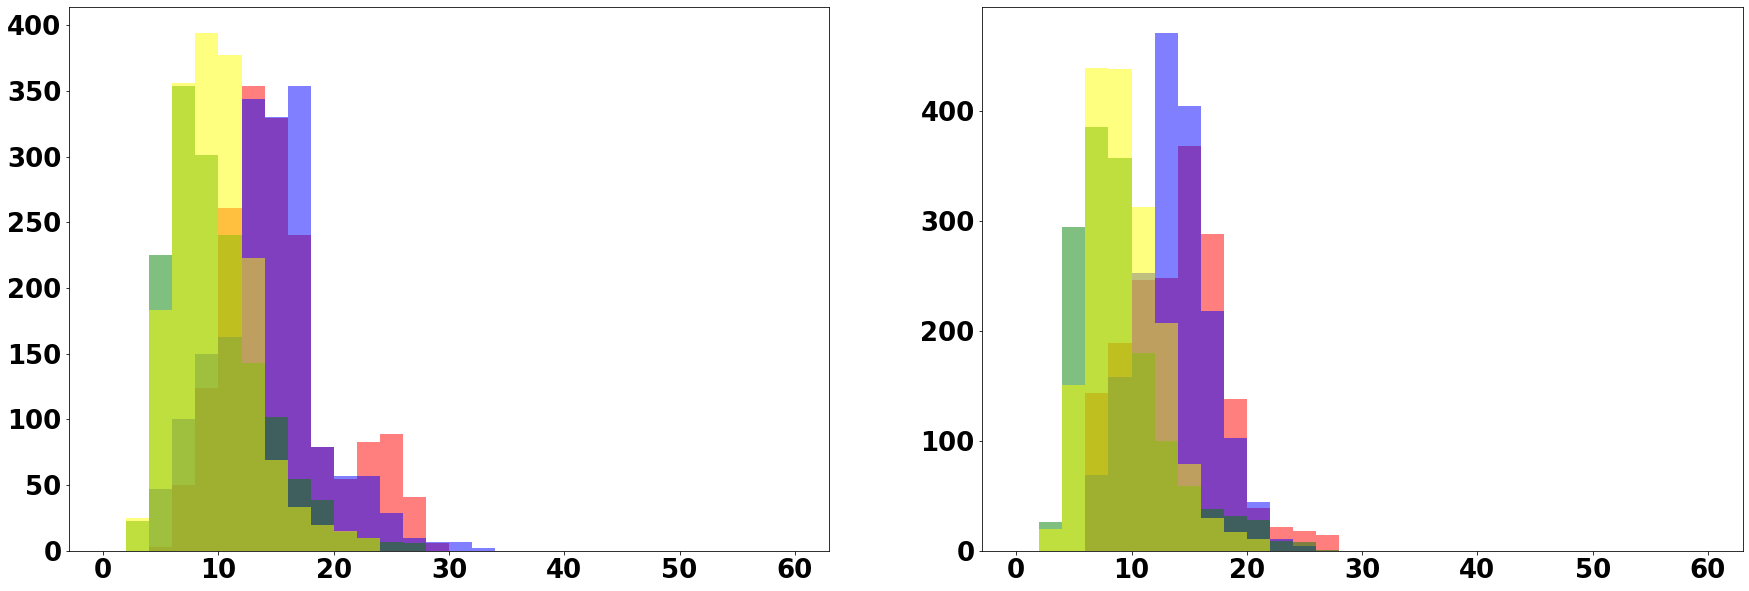

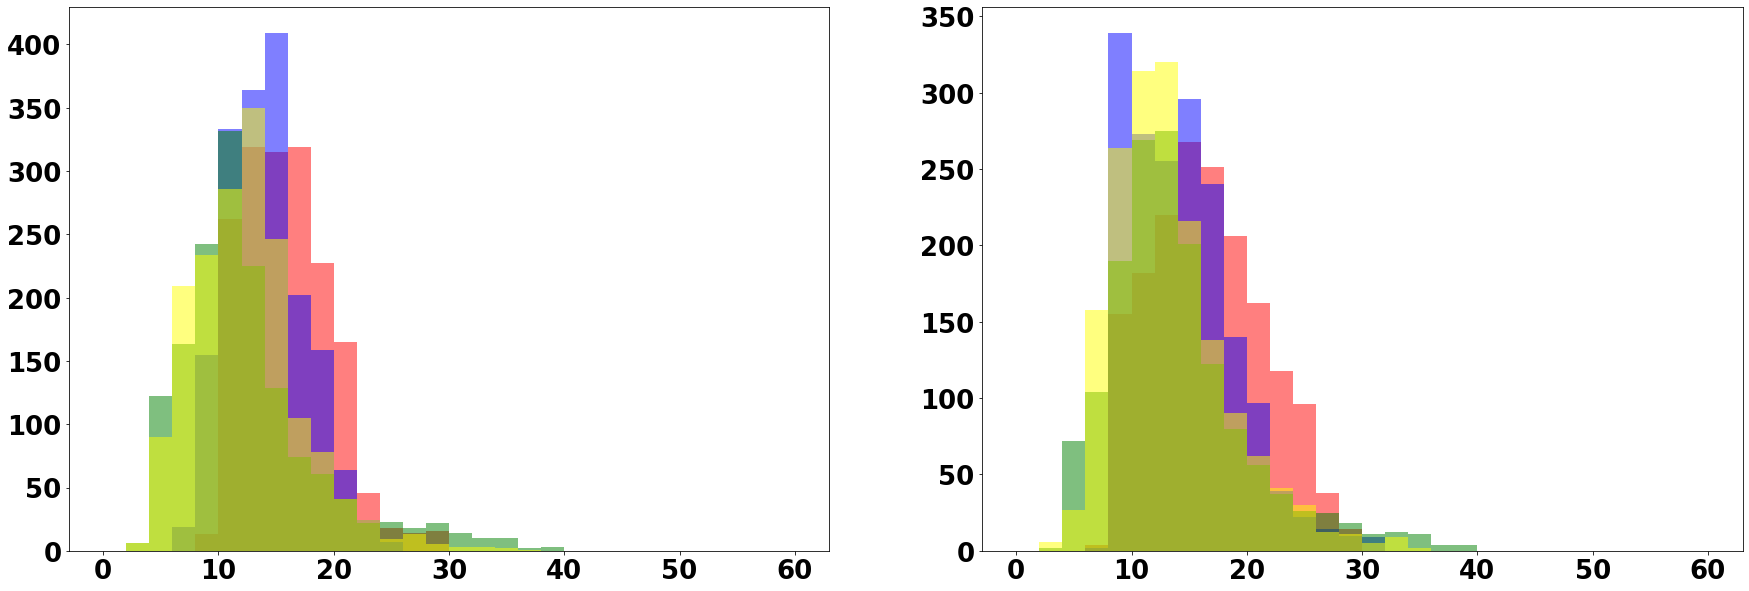

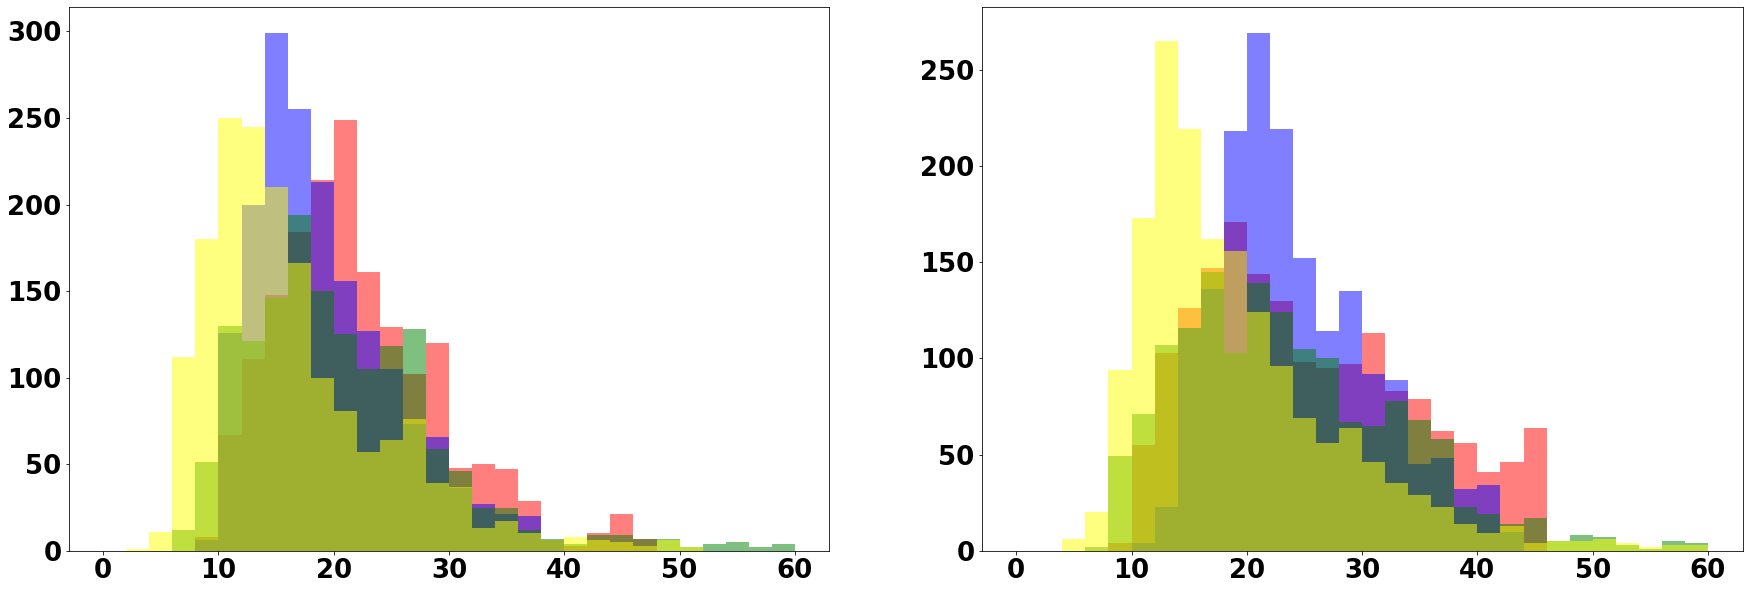

In [36]:
x_reconstructed31 = yhatbr1[0].reshape(71, st*3, d*P)
x_reconstructed32 = yhatbr2[0].reshape(134, st*3, d*P)
er1 = []
er2 = []
for i in range(l, st, 1):
    fig = plt.figure(figsize=(2*15, 10))
    ax = fig.add_subplot(121)
    axx = fig.add_subplot(122)
    for p in range(P):
        db = h5py.File(namee[p], 'r')
        ds = db['Phi']
        ds = np.asarray(ds).astype(np.float32).T
        ds = ds[:, 0:d]
        ds[np.isnan(ds)] = 0.0
        ds[np.isinf(ds)] = 0.0
        lxyz = np.array([[lx, 0, 0],
                 [0, ly, 0],
                 [0, 0, lz]]) 
        
        info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
        info = info['shape_TRIV']
        info = np.asarray(info).astype(np.int32) 
        
        cl1 = np.zeros((DIMM[p]))
        for j in range(71):
            xyz31 = np.dot(DATAallbr1[p][j*st+i], np.linalg.pinv(ds))
            xyz_reconstructed31 = np.dot(np.dot(lxyz, x_reconstructed31[j, i*3:(i+1)*3, p*d:(p+1)*d]), np.linalg.pinv(ds))
            cl1 += np.linalg.norm(np.abs(xyz31 - xyz_reconstructed31), axis=0)/71.0
            
        cl2 = np.zeros((DIMM[p]))        
        for j in range(134):
            xyz32 = np.dot(DATAallbr2[p][j*st+i], np.linalg.pinv(ds))
            xyz_reconstructed32 = np.dot(np.dot(lxyz, x_reconstructed32[j, i*3:(i+1)*3, p*d:(p+1)*d]), np.linalg.pinv(ds))
            cl2 += np.linalg.norm(np.abs(xyz32 - xyz_reconstructed32), axis=0)/134.0
            
        if i == l:
            er1.append(cl1)
            er2.append(cl2)
        else:
            er1[p] += cl1 
            er2[p] += cl2 
            
        ax.hist(cl1, bins=30, color=ch[p], alpha=0.5, range=[0, 60])
        axx.hist(cl2, bins=30, color=ch[p], alpha=0.5, range=[0, 60])
        
        xyz = np.dot(DATAallbr1[p][i], np.linalg.pinv(ds))
        datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=cl1, showscale=True, cmax=60, cmin=0)]
        layout = go.Layout(
            width=600, height=600, 
            scene=go.layout.Scene(
                xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                camera = dict(
                   up=dict(x=0, y=0, z=1),
                   center=dict(x=0, y=0, z=0),
                   eye=dict(x=0, y=2, z=2)
                )
            )
        )
        figp = go.Figure(data=datap, layout=layout)
        #figp.show()
        figp.write_image('compAvReconsEr_br1_' + np.str(p) + '_' + np.str(i) + '.png')

        xyz = np.dot(DATAallbr2[p][i], np.linalg.pinv(ds))
        datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=cl2, showscale=True, cmax=60, cmin=0)]
        layout = go.Layout(
            width=600, height=600, 
            scene=go.layout.Scene(
                xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                camera = dict(
                   up=dict(x=0, y=0, z=1),
                   center=dict(x=0, y=0, z=0),
                   eye=dict(x=0, y=2, z=2)
                )
            )
        )
        figp = go.Figure(data=datap, layout=layout)
        #figp.show()
        figp.write_image('compAvReconsEr_br2_' + np.str(p) + '_' + np.str(i) + '.png')        


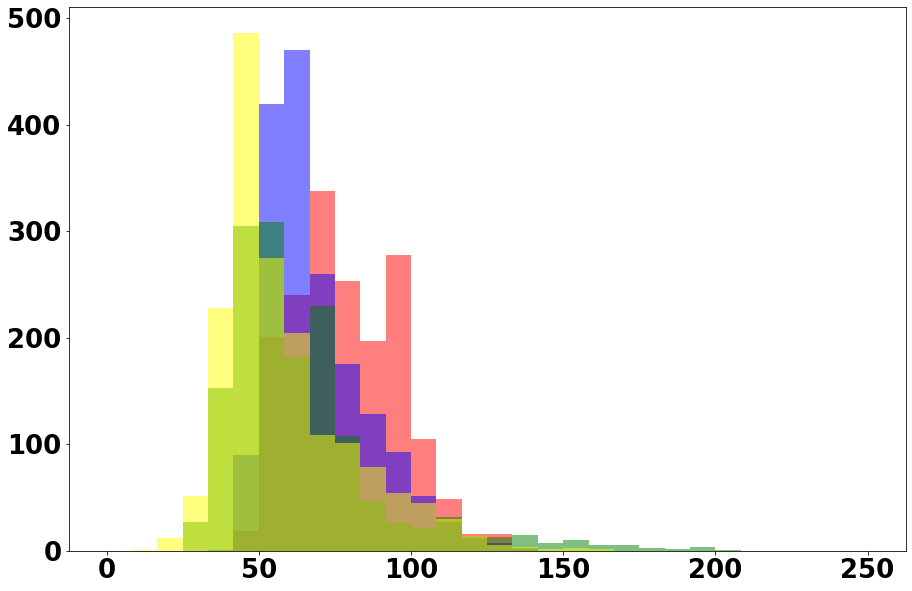

In [37]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111) 
for p in range(P):
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0

    info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
    info = info['shape_TRIV']
    info = np.asarray(info).astype(np.int32)      
    
    ax.hist(er1[p], bins=30, color=ch[p], alpha=0.5, range=[0,250])
    
    xyz = np.dot(DATAallbr1[p][0], np.linalg.pinv(ds))
    datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=er1[p], showscale=True, cmax=200, cmin=0)]
    layout = go.Layout(
        width=600, height=600, 
        scene=go.layout.Scene(
            xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            camera = dict(
               up=dict(x=0, y=0, z=1),
               center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=2, z=2)
            )
        )
    )
    figp = go.Figure(data=datap, layout=layout)
    #figp.show()
    figp.write_image('compAvAcReconsEr_br1_' + np.str(p) + '.png')    

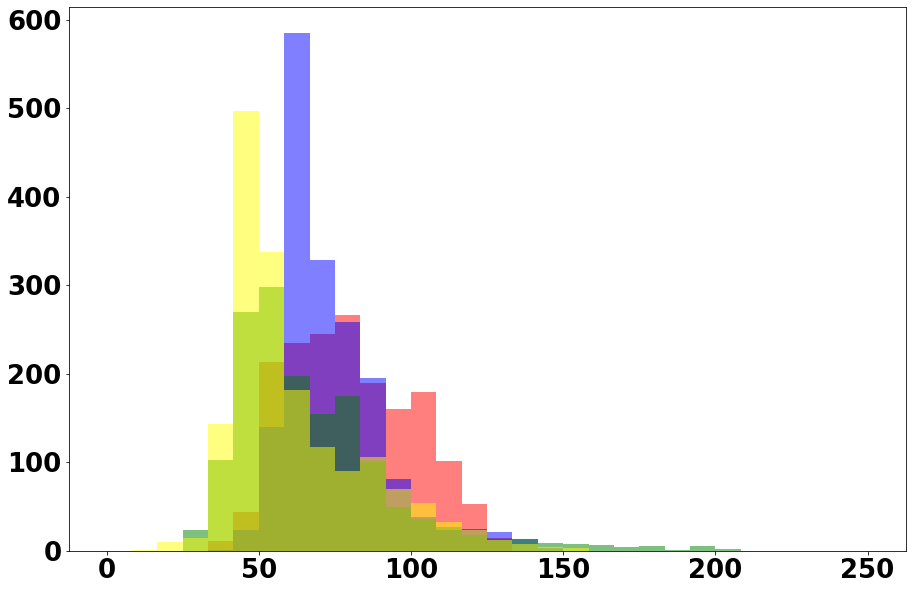

In [38]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111) 
for p in range(P):
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    
    info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
    info = info['shape_TRIV']
    info = np.asarray(info).astype(np.int32)      
    
    ax.hist(er2[p], bins=30, color=ch[p], alpha=0.5, range=[0,250])
    
    xyz = np.dot(DATAallbr2[p][0], np.linalg.pinv(ds))
    datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=er2[p], showscale=True, cmax=200, cmin=0)]
    layout = go.Layout(
        width=600, height=600, 
        scene=go.layout.Scene(
            xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            camera = dict(
               up=dict(x=0, y=0, z=1),
               center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=2, z=2)
            )
        )
    )
    figp = go.Figure(data=datap, layout=layout)
    #figp.show()
    figp.write_image('compAvAcReconsEr_br2_' + np.str(p) + '.png')    

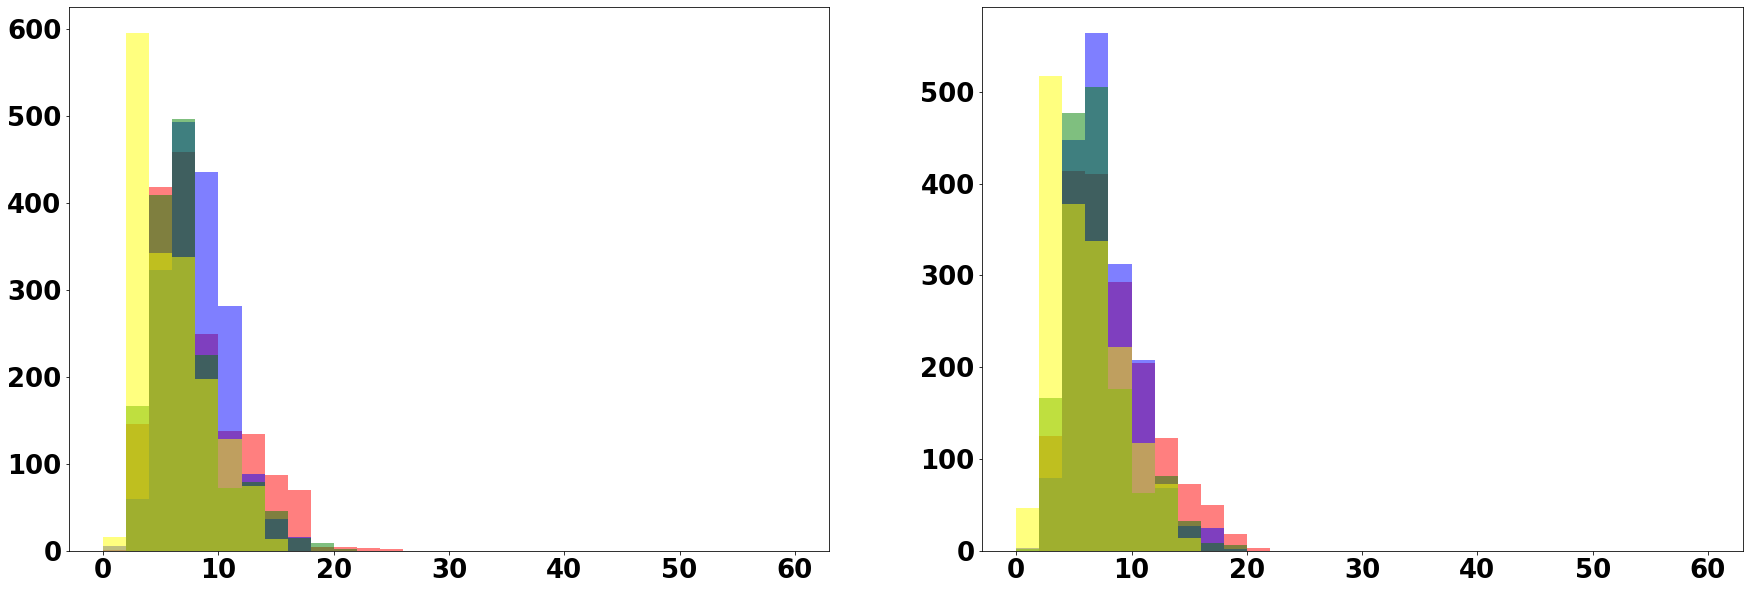

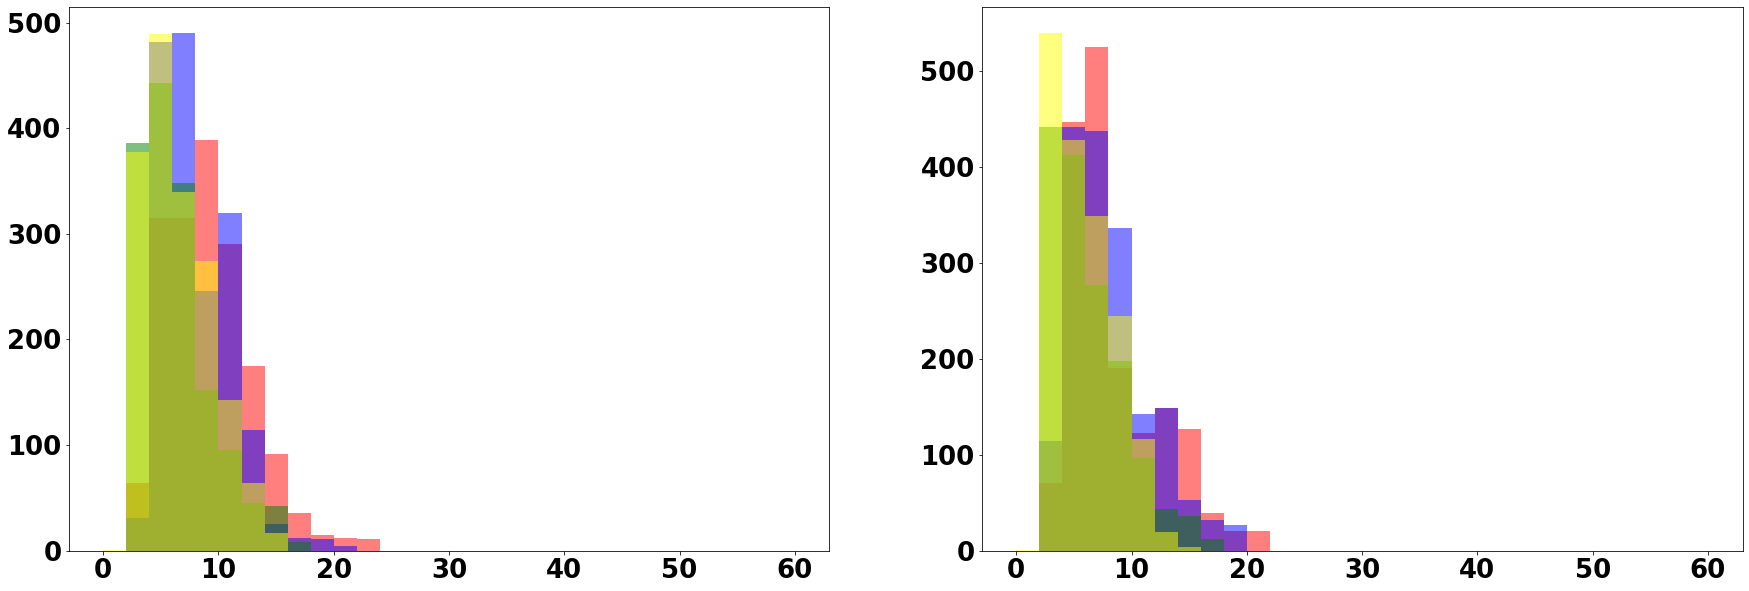

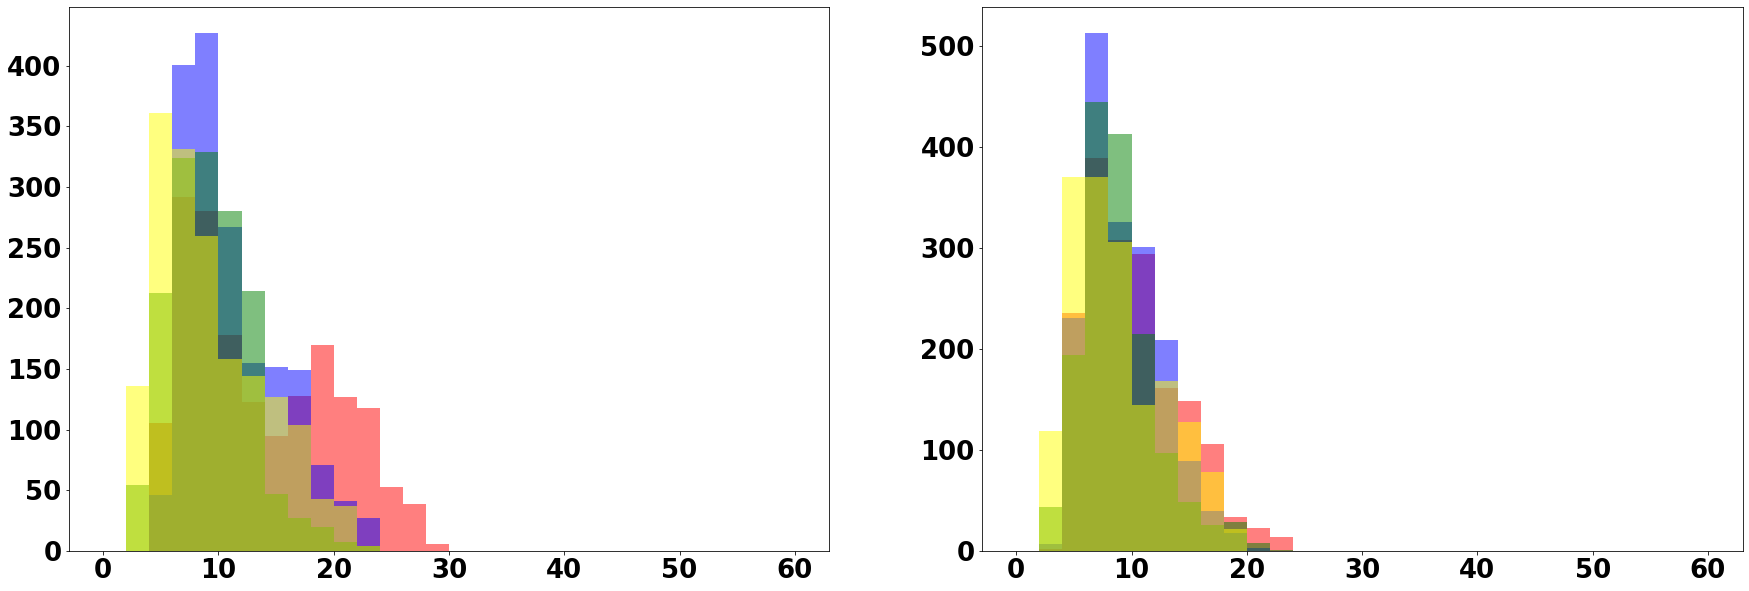

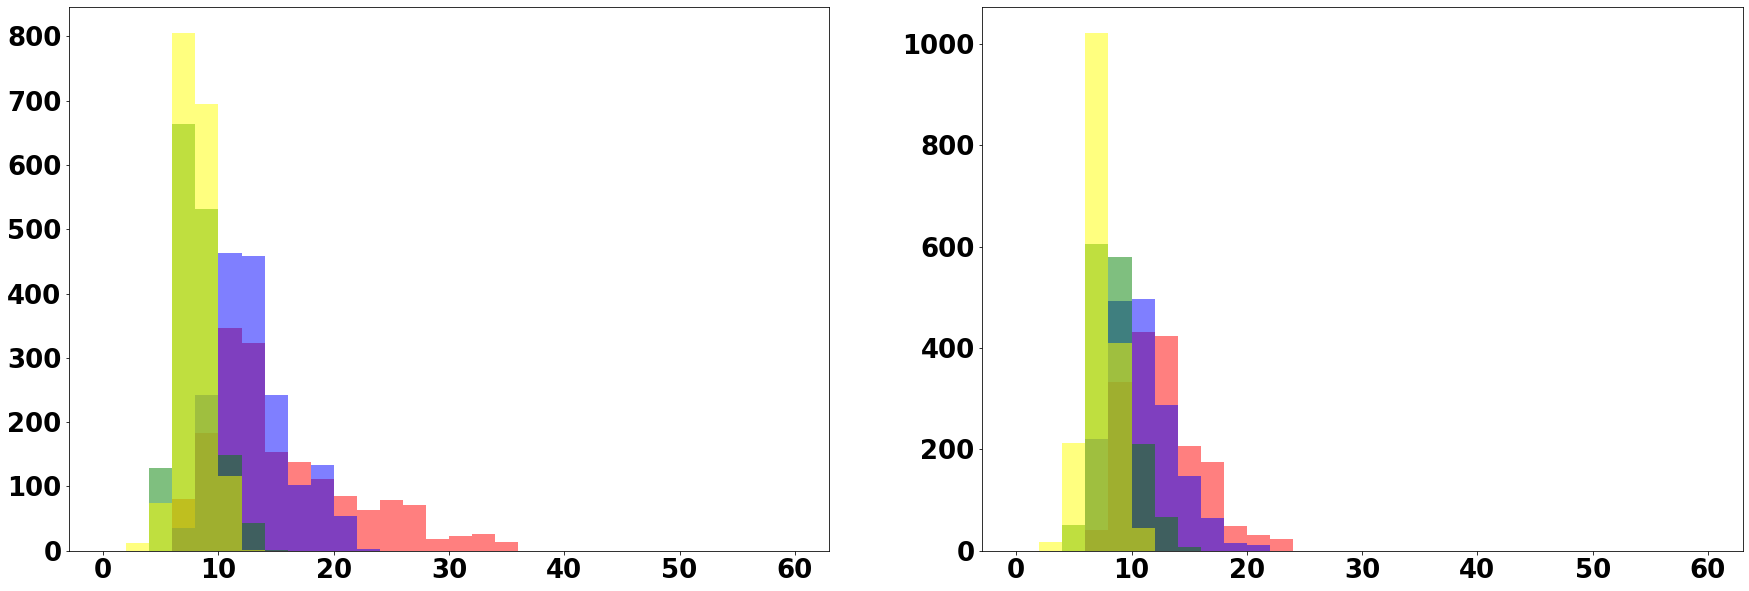

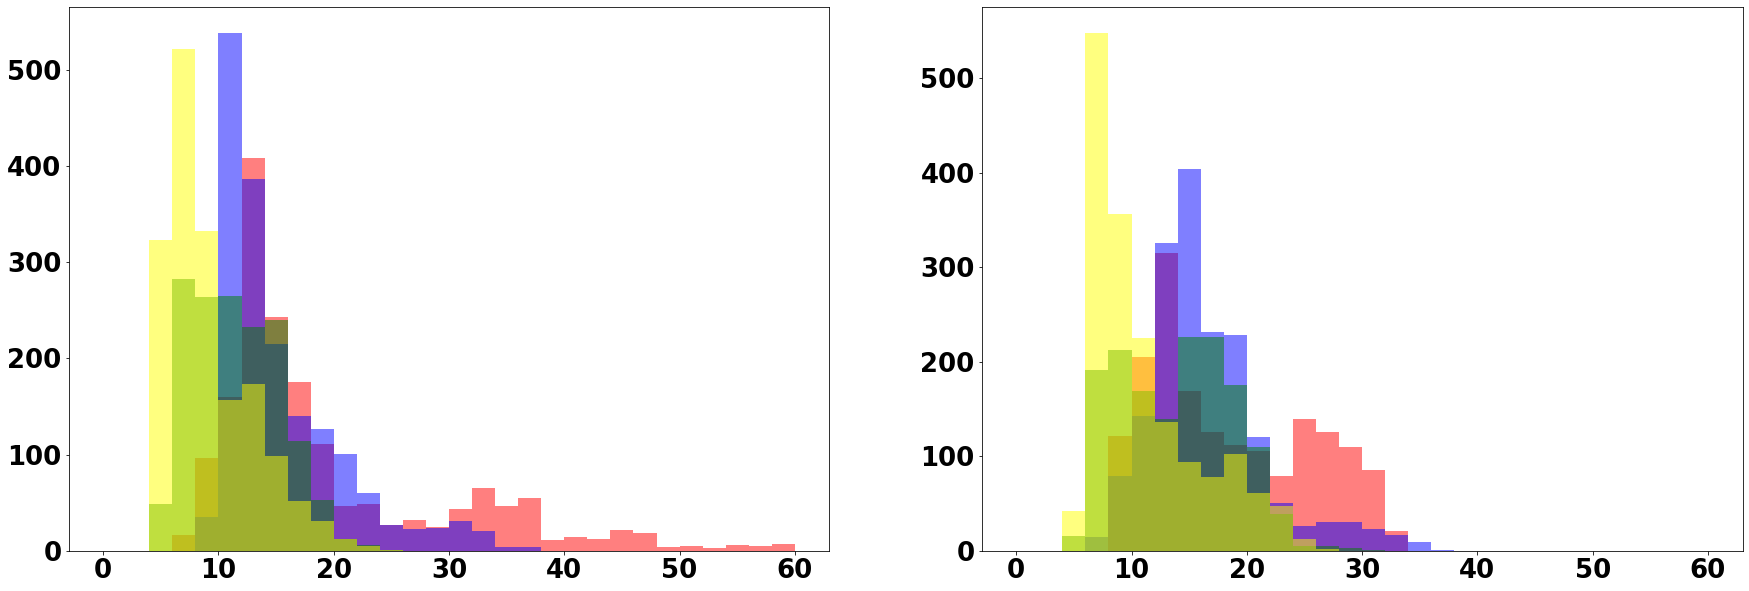

In [39]:
x_reconstructed31 = yhatbr1[1].reshape(71, (st-l)*3, d*P)
x_reconstructed32 = yhatbr2[1].reshape(134, (st-l)*3, d*P)
er1 = []
er2 = []
for i in range(l, st, 1):
    fig = plt.figure(figsize=(2*15, 10))
    ax = fig.add_subplot(121)
    axx = fig.add_subplot(122)
    for p in range(P):
        db = h5py.File(namee[p], 'r')
        ds = db['Phi']
        ds = np.asarray(ds).astype(np.float32).T
        ds = ds[:, 0:d]
        ds[np.isnan(ds)] = 0.0
        ds[np.isinf(ds)] = 0.0
        
        lxyz = np.array([[lx, 0, 0],
                 [0, ly, 0],
                 [0, 0, lz]]) 
        
        info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
        info = info['shape_TRIV']
        info = np.asarray(info).astype(np.int32) 
        
        cl1 = np.zeros((DIMM[p]))
        for j in range(71):
            xyz31 = np.dot(DATAallbr1[p][j*st+i], np.linalg.pinv(ds))
            xyz_reconstructed31 = np.dot(np.dot(lxyz, x_reconstructed31[j, (i-l)*3:(i-l+1)*3, p*d:(p+1)*d]), np.linalg.pinv(ds))
            cl1 += np.linalg.norm(np.abs(xyz31 - xyz_reconstructed31), axis=0)/71.0
            
        cl2 = np.zeros((DIMM[p]))
        for j in range(134):
            xyz32 = np.dot(DATAallbr2[p][j*st+i], np.linalg.pinv(ds))
            xyz_reconstructed32 = np.dot(np.dot(lxyz, x_reconstructed32[j, (i-l)*3:(i-l+1)*3, p*d:(p+1)*d]), np.linalg.pinv(ds))
            cl2 += np.linalg.norm(np.abs(xyz32 - xyz_reconstructed32), axis=0)/134.0

        if i == l:
            er1.append(cl1)
            er2.append(cl2)
        else:
            er1[p] += cl1 
            er2[p] += cl2 
            
        ax.hist(cl1, bins=30, color=ch[p], alpha=0.5, range=[0,60])
        axx.hist(cl2, bins=30, color=ch[p], alpha=0.5, range=[0,60])
        
        xyz = np.dot(DATAallbr1[p][i], np.linalg.pinv(ds))
        datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=cl1, showscale=True, cmax=50, cmin=0)]
        layout = go.Layout(
            width=600, height=600, 
            scene=go.layout.Scene(
                xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                camera = dict(
                   up=dict(x=0, y=0, z=1),
                   center=dict(x=0, y=0, z=0),
                   eye=dict(x=0, y=2, z=2)
                )
            )
        )
        figp = go.Figure(data=datap, layout=layout)
        #figp.show()
        figp.write_image('compAvPredEr_br1_' + np.str(p) + '_' + np.str(i) + '.png')

        xyz = np.dot(DATAallbr2[p][i], np.linalg.pinv(ds))
        datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=cl2, showscale=True, cmax=50, cmin=0)]
        layout = go.Layout(
            width=600, height=600, 
            scene=go.layout.Scene(
                xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
                camera = dict(
                   up=dict(x=0, y=0, z=1),
                   center=dict(x=0, y=0, z=0),
                   eye=dict(x=0, y=2, z=2)
                )
            )
        )
        figp = go.Figure(data=datap, layout=layout)
        #figp.show()
        figp.write_image('compAvPredEr_br2_' + np.str(p) + '_' + np.str(i) + '.png')  

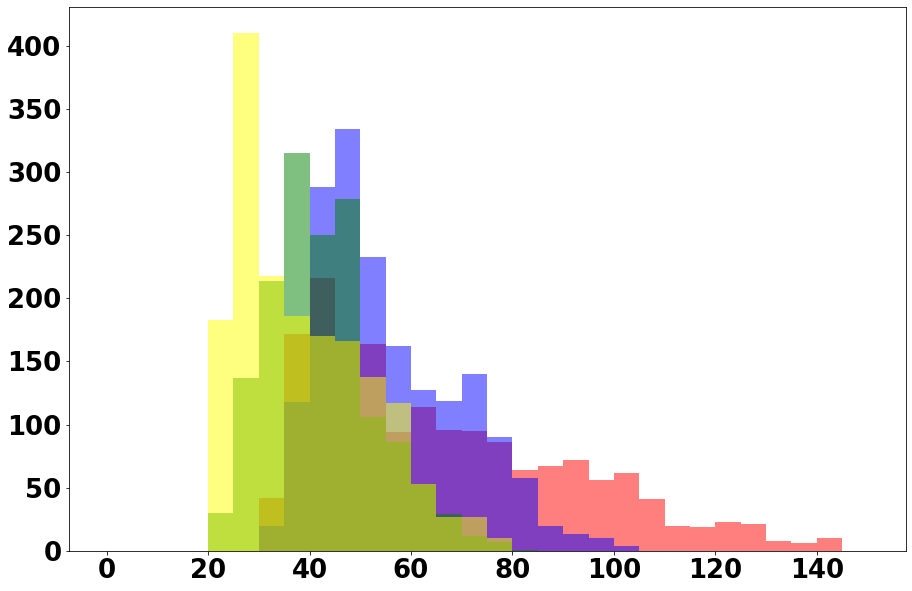

In [40]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111) 
for p in range(P):
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    
    info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
    info = info['shape_TRIV']
    info = np.asarray(info).astype(np.int32)     
    
    ax.hist(er1[p], bins=30, color=ch[p], alpha=0.5, range=[0,150])
    
    xyz = np.dot(DATAallbr1[p][0], np.linalg.pinv(ds))
    datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=er1[p], showscale=True, cmax=150, cmin=0)]
    layout = go.Layout(
        width=600, height=600, 
        scene=go.layout.Scene(
            xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            camera = dict(
               up=dict(x=0, y=0, z=1),
               center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=2, z=2)
            )
        )
    )
    figp = go.Figure(data=datap, layout=layout)
    #figp.show()
    figp.write_image('compAvAcPredEr_br1_' + np.str(p) + '.png')    

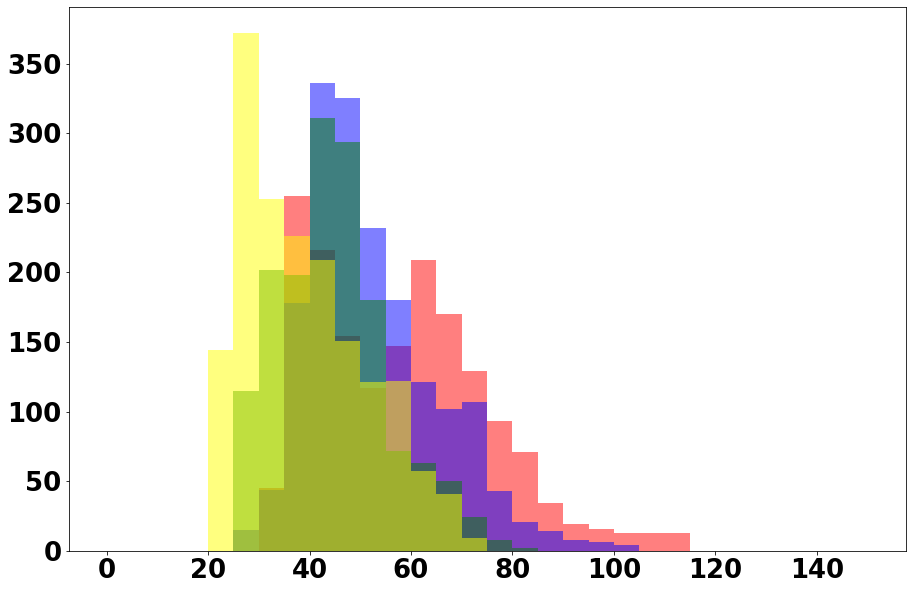

In [41]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111) 
for p in range(P):
    db = h5py.File(namee[p], 'r')
    ds = db['Phi']
    ds = np.asarray(ds).astype(np.float32).T
    ds = ds[:, 0:d]
    ds[np.isnan(ds)] = 0.0
    ds[np.isinf(ds)] = 0.0
    
    info = h5py.File('/home/mabbasloo/Documents/carCrashData/meshInfo_' + np.str(Comp[p]) + '.mat', 'r')
    info = info['shape_TRIV']
    info = np.asarray(info).astype(np.int32)      
    
    ax.hist(er2[p], bins=30, color=ch[p], alpha=0.5, range=[0,150])
    
    xyz = np.dot(DATAallbr2[p][0], np.linalg.pinv(ds))
    datap = [go.Mesh3d(x=xyz[0], y=xyz[1], z=xyz[2], i=info[0]-1, j=info[1]-1, k=info[2]-1, intensity=er2[p], showscale=True, cmax=150, cmin=0)]
    layout = go.Layout(
        width=600, height=600, 
        scene=go.layout.Scene(
            xaxis = go.layout.scene.XAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            yaxis = go.layout.scene.YAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            zaxis = go.layout.scene.ZAxis(showgrid=False, showline=False, showticklabels=False, title_text='', showbackground=False),
            camera = dict(
               up=dict(x=0, y=0, z=1),
               center=dict(x=0, y=0, z=0),
               eye=dict(x=0, y=2, z=2)
            )
        )
    )
    figp = go.Figure(data=datap, layout=layout)
    #figp.show()
    figp.write_image('compAvAcPredEr_br2_' + np.str(p) + '.png')    

network

In [ ]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model



# define model
model2 = Sequential()
model2.add(LSTM(1000, activation='relu', input_shape=(n_in, 3*d*P)))
model2.add(RepeatVector(n_in))
model2.add(LSTM(1500, activation='relu', return_sequences=True))
model2.add(TimeDistributed(Dense(3*d*P)))
model2.compile(optimizer='adam', loss='mse')

# fit model
model2.fit(seq_in, seq_in, epochs=100, verbose=0)

# connect the encoder LSTM as the output layer
model2 = Model(inputs=model2.inputs, outputs=model2.layers[0].output)
plot_model(model2, show_shapes=True, to_file='lstm_encoder.png')

# get the feature vector for the input sequence
yhat2_in = model2.predict(seq_in)
yhat2_test = model2.predict(seq_test)

In [ ]:
yhat2_testbr1 = model2.predict(seq_testbr1)
yhat2_testbr2 = model2.predict(seq_testbr2)
print (yhat2_testbr1.shape, yhat2_testbr2.shape)

In [ ]:
yhat2 = np.append(yhat2_testbr1, yhat2_testbr2, axis=0)
X_embedded2 = TSNE(n_components=2).fit_transform(yhat2)

In [ ]:
c = ['r', 'b']
m = ['o', '^']

plt.figure(figsize=(10, 10))
plt.scatter(X_embedded2[0:71, 0], X_embedded2[0:71, 1], c=c[0], marker=m[0])
plt.scatter(X_embedded2[71:, 0], X_embedded2[71:, 1], c=c[1], marker=m[1])
#plt.xlabel('latent 1')
#plt.ylabel('latent 2')
plt.show()